In [3]:
from ecell4 import *
import numpy as np
%matplotlib inline
import math
import sys
import matplotlib.pyplot as plt
rng = core.GSLRandomNumberGenerator()

phios = [0.,0.05,0.1,0.15,0.18]
simrun = 200
phit = 0.001
L = 0.2
Vt = L**3
rm = 0.005
Vp = 4./3*math.pi*rm**3
Do = 0
Dt = 1    
rv = rm#1.66097*rm
H = 3*rv*2
dt = (2*rv)**2 / (6*Dt)
tt = np.logspace(math.log10(2.1*dt),1,30)
tt = np.insert(tt,0,dt)
tt = np.insert(tt,0,0.)
dur = tt[-1]
print 'L={},rm={},rv={},Do={},Dt={},dt={}'.format(L,rm,rv,Do,Dt,dt)
w = spatiocyte.SpatiocyteWorld(Real3(L,L,L),rv)
rs = w.row_size()
ls = w.layer_size()
cs = w.col_size()
Nmv = cs*ls*rs
Nt = int(phit*Nmv)
x,y,z = tuple(w.actual_lengths())
print 'defined volume',L**3
print 'actual volume',y*z*x
print 'no of voxels',Nmv

def run(phio):
    msd = np.zeros(len(tt),float)
    w = spatiocyte.SpatiocyteWorld(Real3(H,L,L),rv)
    x,y,z = w.actual_lengths()
    with species_attributes():
        O | {'D':str(Do),'radius':str(rv)}
        T | {'D':str(Dt),'radius':str(rv)}
    m=get_model()
    w.bind_to(m)
    #w.add_structure(Species('M'),PlanarSurface(ori,unit0,unit1))
    w.add_molecules(Species('T'),Nt)
    w.add_molecules(Species('O'),No)
    sim = spatiocyte.SpatiocyteSimulator(w)
    pids = [pid for pid, p in w.list_particles(Species("T"))] #particle IDs
    #obs = FixedIntervalTrajectoryObserver(dt,pids)
    obs = TimingTrajectoryObserver(tt,pids,True,dt)
    sim.run(dur,obs)
    data=obs.data()
    #viz.plot_trajectory(obs)
    for i in range(Nt):
        #print 'tracer',i
        msd += np.array(
            [np.linalg.norm(np.array(tuple(pos)) - np.array(tuple(data[i][0]))) ** 2
                 for pos in data[i]]) 

    msd = msd/Nt
    return msd

L=0.2,rm=0.005,rv=0.005,Do=0,Dt=1,dt=1.66666666667e-05
defined volume 0.008
actual volume 0.00970716189213
no of voxels 13728


phio 0.0
occupancy of tracer 0.00094696969697 occupancy of obstacles 0.0
Nt 13 No 0
total traj 2600
phio 0.05
occupancy of tracer 0.00094696969697 occupancy of obstacles 0.0499708624709
Nt 13 No 686
total traj 2600
phio 0.1
occupancy of tracer 0.00094696969697 occupancy of obstacles 0.0999417249417
Nt 13 No 1372
total traj 2600
phio 0.15
occupancy of tracer 0.00094696969697 occupancy of obstacles 0.149985431235
Nt 13 No 2059
total traj 2600
phio 0.18
occupancy of tracer 0.00094696969697 occupancy of obstacles 0.179997086247
Nt 13 No 2471
total traj 2600


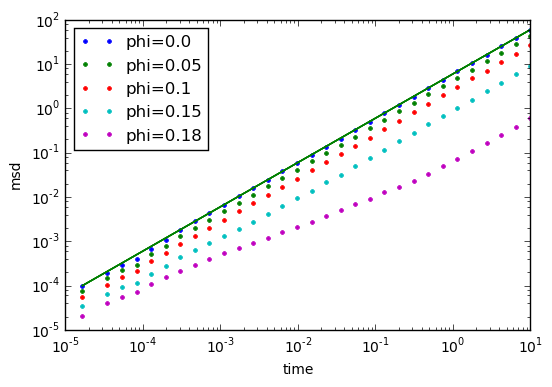

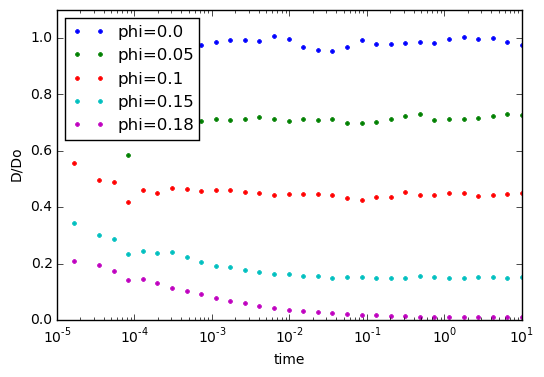

In [4]:
f1,ax1 = plt.subplots(1)
f2,ax2 = plt.subplots(1)
Deffall = []
for phio in phios:
    print 'phio',str(phio)
    No = int(phio*Nmv)
    print 'occupancy of tracer',float(Nt)/Nmv,'occupancy of obstacles',float(No)/Nmv
    #phi_hcp = float(No)/Nmv
    #print 'phi_hcp/phi_BD=',str(phi_hcp/phio)
    print 'Nt',Nt,'No',No
    #MSD = []
    print 'total traj',simrun*Nt
    for rr in range(simrun):
        #print 'run',rr
        if (rr!=0):  MSD += run(phio)
        else: MSD = run(phio)
    MSD /= simrun
    fn = open('data/3Dcrowding_LS_phi'+str(phio)+'rv1rm.csv','w')
    np.savetxt(fn,np.column_stack((tt,MSD)),delimiter=',',fmt='%s')
    fn.close()
    ax1.loglog(tt,MSD,'.',label='phi='+str(phio))
    ax1.plot(tt,6*Dt*tt,'g-')  #theoretical line
    ax1.set_xlabel("time")
    ax1.set_ylabel("msd")
    Deff = MSD[1:]/tt[1:]/6/Dt
    ax2.semilogx(tt[1:],Deff,'.',label='phi='+str(phio))
    ax2.set_xlabel("time")
    ax2.set_ylabel("D/Do")
    ax2.set_ylim(0,1.1)
    Deffall.append(Deff)
ax1.legend(loc='best')
ax2.legend(loc='best') 
plt.show()
Deffall = np.array(Deffall)
Deffs=[]
for dff in Deffall:
    Deffs.append(np.mean(dff[(tt>1)[1::]]))

In [5]:
f1.savefig("figure/3DLSrv=rm_diffusion_MSD_t.png",format='png',dpi=100)    
f2.savefig("figure/3DLSrv=rm_diffusion_Deff_t.png",format='png',dpi=100)

In [21]:
Deffs[0]

0.99311952298354678

phi= 0.0  Deff= 0.993119522984
phi= 0.05  Deff= 0.720711277201
phi= 0.1  Deff= 0.446296193909
phi= 0.15  Deff= 0.150640277104
phi= 0.18  Deff= 0.0102047317441


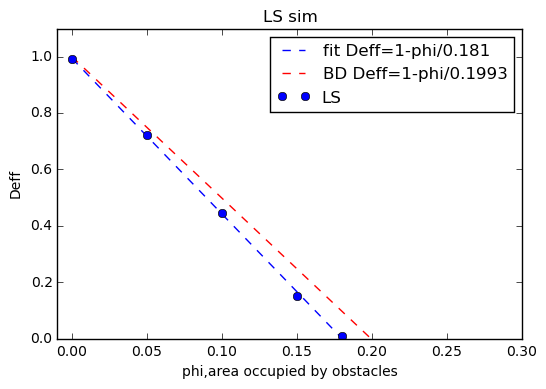

In [25]:
from ecell4 import *
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit

def lin(x,m,c):
    return m*x+c 
c1,c2 = curve_fit(lin,phios,Deffs)
xx = np.linspace(0,0.2,10)
plt.plot(xx,[c1[0]*i+c1[1] for i in xx],'--',label='fit Deff=1-phi/{:.3f}'.format(-1./c1[0]))
plt.plot(xx,[(-1./0.1993)*i+1. for i in xx],'r--',label='BD Deff=1-phi/0.1993')
plt.plot(phios,Deffs,'bo',label='LS')
#plt.plot(phiobd,Deffbd,'ro-',label='BD')
plt.title('LS sim')
plt.xlabel('phi,area occupied by obstacles')
plt.ylabel('Deff')
plt.xlim(-0.01,0.3)
plt.ylim(0.0,1.1)
plt.legend(loc='best')
for i,j in zip(phios,Deffs):
    print 'phi=',str(i),' Deff=',str(j)
#plt.savefig("figure/2DLSBD_diffusion_Deff_phir.png",format='png',dpi=100)
plt.show()

In [31]:
Nos = [31194, 62388 ,93583, 112299, 124777]
phil = [float(i)/206912 for i in Nos]
print phil
for i,j in zip(phios[1:],phil):
    print 'phi_hcp/phi_BD',j/i
print 0.5/0.18
print 'area=',49,'lattice area=',str(7.011272387006512*7.03416)

[0.15075974327250233, 0.30151948654500466, 0.45228406278997835, 0.5427379755644912, 0.6030438060624806]
phi_hcp/phi_BD 3.01519486545
phi_hcp/phi_BD 3.01519486545
phi_hcp/phi_BD 3.01522708527
phi_hcp/phi_BD 3.01521097536
phi_hcp/phi_BD 3.01521903031
2.77777777778
area= 49 lattice area= 49.3184117738
